# SGD Noise, Learning-Rate Schedules, and Batch-Size Strategies
## Logistic regression on a synthetic ill-conditioned dataset

In this notebook we study **optimization dynamics** in a controlled setting:
regularized logistic regression trained with stochastic gradient descent (SGD).

We run three experiments:
- **Experiment 1 (batch size):** how batch size affects convergence and noise
- **Experiment 2 (schedules):** how learning-rate decay impacts dynamics
- **Experiment 3 (progressive):** whether increasing batch size during training helps

### Two diagnostics tracked per epoch
1. **Suboptimality:** $f(\theta_k) - f(\theta^*)$
2. **Search-direction variance:** a dimensionless measure of how noisy the minibatch directions are

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Configuration: use FAST_MODE for quick testing, otherwise production runs
FAST_MODE = True
if FAST_MODE:
    EPOCHS = 800     # Quick runs; use 5000 for high-quality plots
else:
    EPOCHS = 5000

# Hyperparameters
ALPHA0 = 1e-3          # Initial learning rate
LAMBDA = 1e-4        # L2 regularization strength


## 2. Synthetic dataset with ill-conditioned features

We generate features $X \in \mathbb{R}^{n \times d}$ with logarithmically spaced scaling
(ranging from 1 to 1000 across dimensions). This creates strong anisotropy that makes
optimization behavior more interesting and closer to realistic ill-conditioned problems.

In [40]:
def make_synthetic_logistic(n=5000, d=40, seed=0):
    """Generate ill-conditioned logistic regression dataset."""
    rng = np.random.default_rng(seed)

    # Features with logarithmically spaced scaling (creates anisotropy)
    X = rng.normal(size=(n, d))
    scales = np.logspace(0, 3, d)   # Scale ranges from 1 to 1000
    X = X * scales

    # Generate binary labels from logistic model
    w_true = rng.normal(size=d)
    logits = X @ w_true
    p = 1.0 / (1.0 + np.exp(-logits))
    y = rng.binomial(1, p)

    return X.astype(np.float64), y.astype(np.int32), w_true


X, y, w_true = make_synthetic_logistic(n=6000, d=20, seed=0)
print("X shape:", X.shape, "| y shape:", y.shape)
print("y mean (class balance):", y.mean())

X shape: (6000, 20) | y shape: (6000,)
y mean (class balance): 0.49266666666666664


/var/folders/pv/7xq94jdd4d51wrjpm4h32qj00000gn/T/ipykernel_30010/2563261163.py:13: RuntimeWarning: overflow encountered in exp
  p = 1.0 / (1.0 + np.exp(-logits))


## 3. Objective: regularized logistic regression

We minimize:
$$f(w) = \frac{1}{n}\sum_{i=1}^n \ell(\langle x_i, w\rangle, y_i) + \frac{\lambda}{2}\|w\|^2,$$
where $\ell$ is the logistic loss.

We implement:
- stable sigmoid
- loss
- gradient
- Hessian (used only if we want a Newton reference solution)

In [41]:
def sigmoid(z):
    """Numerically stable sigmoid to avoid overflow."""
    z = z.astype(np.float64, copy=False)
    out = np.empty_like(z, dtype=np.float64)
    # Handle positive and negative values separately for stability
    pos = (z >= 0)
    neg = ~pos
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[neg])
    out[neg] = ez / (1.0 + ez)
    return out

def logloss(w, X, y, lam=1e-4):
    """Logistic loss with L2 regularization."""
    z = X @ w
    p = sigmoid(z)
    eps = 1e-12
    # Binary cross-entropy loss
    loss = -np.mean(y * np.log(p+eps) + (1-y)*np.log(1-p+eps))
    loss += 0.5 * lam * np.sum(w**2)  # Add L2 penalty
    return float(loss)

def grad_logloss(w, X, y, lam=1e-4):
    """Gradient of logistic loss (used by SGD)."""
    z = X @ w
    p = sigmoid(z)
    grad = (X.T @ (p - y)) / X.shape[0]
    grad += lam * w  # Gradient of L2 penalty
    return grad.astype(np.float64)

def hess_logloss_full(w, X, y, lam=1e-4, damping=1e-8):
    n, d = X.shape
    z = X @ w
    p = sigmoid(z)
    w_diag = p*(1-p)
    WX = X * w_diag[:,None]
    H = (X.T @ WX) / n

    reg = np.zeros((d,d))
    reg[1:,1:] = lam*np.eye(d-1)
    H = H + reg + damping*np.eye(d)
    return H



## 4. Reference optimum $f(\theta^*)$

To measure suboptimality, we need a reference value $f^*$.
In research code, we can compute it via Newton's method.
For speed, we can hard-code a precomputed value to save time.

Below:
- we keep the precomputed value (fast)
- and optionally provide Newton solve (slow)

In [42]:
# Precomputed optimal loss value for suboptimality measurements
f_opt = 1.101595433540e-03
print("Using precomputed f_opt =", f_opt)


def newton_solve_opt(X, y, lam=1e-4, tol=1e-10, max_iter=50):
    """Compute optimal value via Newton's method (expensive, for reference)."""
    d = X.shape[1]
    w = np.zeros(d)

    for it in range(max_iter):
        g = grad_logloss(w, X, y, lam)
        ng = np.linalg.norm(g)
        if ng < tol:
            print(f"[Newton] Converged in {it} iterations | ||g||={ng:.2e}")
            break

        # Newton step: w = w - H^{-1} * g
        H = hess_logloss_full(w, X, y, lam)
        step = np.linalg.solve(H, g)
        w = w - step

    f_star = logloss(w, X, y, lam)
    print(f"[Newton] f* = {f_star:.12e}")
    return w, f_star


# Uncomment to recompute f_opt (slow; needed if data or regularization changes)# w_star, f_opt = newton_solve_opt(X, y, lam=LAMBDA)

Using precomputed f_opt = 0.00110159543354


## Polynomial learning rate scheduler

To reduce noise and improve convergence in later stages, we implement a polynomial decay schedule:

$$\alpha_k = \frac{\alpha_0}{(1 + \gamma k)^p},$$

where $\alpha_0$ is the initial learning rate, $\gamma$ controls the decay rate, $k$ is the epoch, and $p$ is the power (typically 1).

This schedule starts with a larger step size for exploration and gradually decreases it, allowing the optimizer to make fine adjustments near the optimum without overshooting.

In [43]:
def poly_scheduler(epoch, alpha0, decay=5e-3, power=1):
    return alpha0 / ((1 + decay * epoch) ** power)

## 5. A diagnostic for SGD noise: direction variance

Within each epoch, SGD produces a sequence of update directions $d_1, \dots, d_M$
(one per mini-batch). We measure how noisy these directions are by:

$$\text{dir\_var} = \frac{\mathbb{E}\|d_i - \bar{d}\|^2}{\|\bar{d}\|^2}, \quad \bar{d} = \mathbb{E}[d_i].$$

Interpretation:
- small dir_var  → mini-batch directions agree (low stochastic noise)
- large dir_var  → directions are highly variable (noisy dynamics)

## 6. SGD runner (fixed batch size)

We implement full-epoch SGD with shuffling, mini-batch updates, and per-epoch tracking
of loss, suboptimality, and direction variance (defined above).

In [44]:
def run_sgd(
    X, y, lam=1e-4,
    epochs=300, batch_size=8,
    alpha0=1e-3, scheduler=None,
    seed=0, f_opt=None
):
    n, d = X.shape
    rng = np.random.default_rng(seed)
    w = np.zeros(d)

    hist_loss, hist_subopt, hist_var, hist_epoch = [], [], [], []

    for ep in range(epochs):
        lr = alpha0 if scheduler is None else scheduler(ep, alpha0)

        idx = rng.permutation(n)
        Xs, ys = X[idx], y[idx]

        dirs = []
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            g = grad_logloss(w, Xs[start:end], ys[start:end], lam)
            d_step = -lr * g
            dirs.append(d_step)
            w = w + d_step

        f = logloss(w, X, y, lam)
        hist_loss.append(f)
        hist_subopt.append(f - f_opt)
        hist_epoch.append(ep)

        D = np.stack(dirs, axis=0)
        mean_d = D.mean(axis=0)
        diff = D - mean_d
        num = np.mean(np.sum(diff * diff, axis=1))
        denom = np.linalg.norm(mean_d) ** 2 + 1e-12
        hist_var.append(num / denom)

    return {
        "epoch": np.array(hist_epoch),
        "loss": np.array(hist_loss),
        "subopt": np.array(hist_subopt),
        "dir_var": np.array(hist_var),
    }

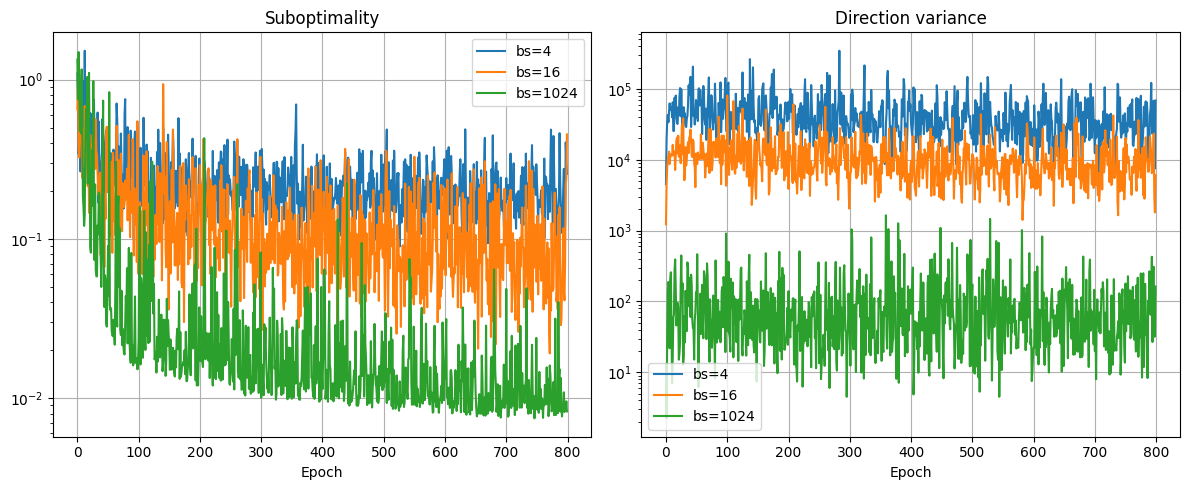

In [45]:
bs_list = [4, 16, 1024]
histories_B = {}

for bs in bs_list:
    h = run_sgd(
        X, y, lam=LAMBDA,
        epochs=EPOCHS, batch_size=bs,
        alpha0=ALPHA0, scheduler=None,
        seed=0, f_opt=f_opt
    )
    histories_B[bs] = h
    pd.DataFrame(h).assign(batch_size=bs).to_csv(
        f"csv_synthetic/expB_bs{bs}.csv", index=False
    )

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for bs in bs_list:
    plt.semilogy(histories_B[bs]["epoch"], histories_B[bs]["subopt"], label=f"bs={bs}")
plt.title("Suboptimality")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.subplot(1,2,2)
for bs in bs_list:
    plt.semilogy(histories_B[bs]["epoch"], histories_B[bs]["dir_var"], label=f"bs={bs}")
plt.title("Direction variance")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()

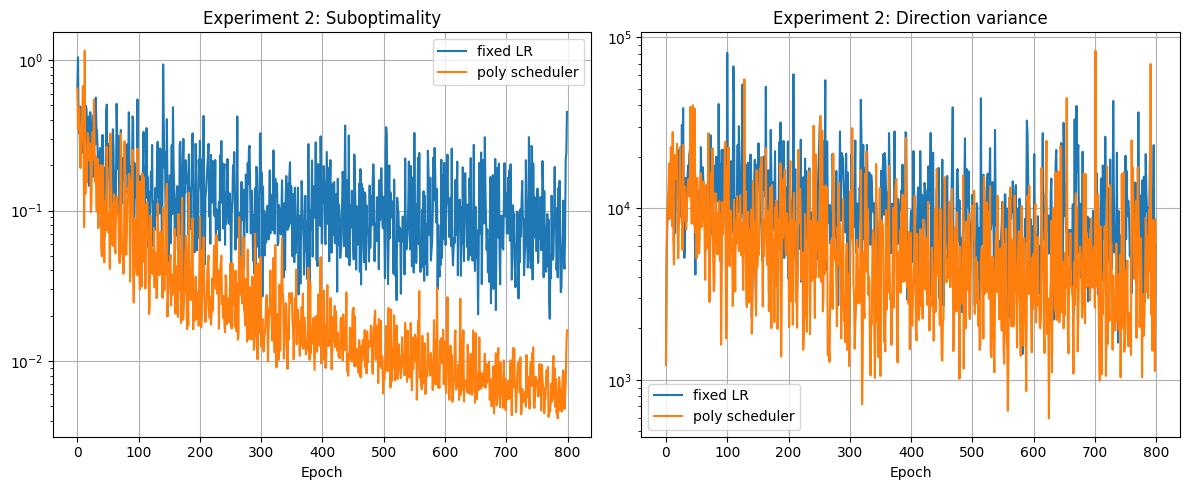

In [46]:
bsA = 16

hist_fixed = run_sgd(
    X, y, lam=LAMBDA,
    epochs=EPOCHS, batch_size=bsA,
    alpha0=ALPHA0, scheduler=None,
    seed=0, f_opt=f_opt
)

hist_sched = run_sgd(
    X, y, lam=LAMBDA,
    epochs=EPOCHS, batch_size=bsA,
    alpha0=ALPHA0,
    scheduler=lambda ep, e0: poly_scheduler(ep, e0, decay=0.02),
    seed=0, f_opt=f_opt
)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.semilogy(hist_fixed["epoch"], hist_fixed["subopt"], label="fixed LR")
plt.semilogy(hist_sched["epoch"], hist_sched["subopt"], label="poly scheduler")
plt.title("Experiment 2: Suboptimality")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.semilogy(hist_fixed["epoch"], hist_fixed["dir_var"], label="fixed LR")
plt.semilogy(hist_sched["epoch"], hist_sched["dir_var"], label="poly scheduler")
plt.title("Experiment 2: Direction variance")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()

## 8. Progressive batch size

A common strategy is to start with small batches (cheap, noisy updates)
and gradually increase batch size (more accurate updates).

We implement a linear schedule from `bs_start` to `bs_end`.

In [47]:
def run_sgd_progressive(
    X, y, lam=1e-4,
    epochs=300,
    bs_start=8, bs_end=512,
    alpha0=1e-3, seed=0, f_opt=None
):
    n, d = X.shape
    rng = np.random.default_rng(seed)
    w = np.zeros(d)

    hist_loss, hist_subopt, hist_var, hist_epoch = [], [], [], []

    for ep in range(epochs):
        frac = ep / (epochs - 1) if epochs > 1 else 1.0
        bs = int(bs_start + frac * (bs_end - bs_start))
        bs = max(1, min(bs, n))

        idx = rng.permutation(n)
        Xs, ys = X[idx], y[idx]

        dirs = []
        for start in range(0, n, bs):
            end = min(start + bs, n)
            g = grad_logloss(w, Xs[start:end], ys[start:end], lam)
            d_step = -alpha0 * g
            dirs.append(d_step)
            w = w + d_step

        f = logloss(w, X, y, lam)
        hist_loss.append(f)
        hist_subopt.append(f - f_opt)
        hist_epoch.append(ep)

        D = np.stack(dirs, axis=0)
        mean_d = D.mean(axis=0)
        diff = D - mean_d
        num = np.mean(np.sum(diff * diff, axis=1))
        denom = np.linalg.norm(mean_d) ** 2 + 1e-12
        hist_var.append(num / denom)

    return {
        "epoch": np.array(hist_epoch),
        "loss": np.array(hist_loss),
        "subopt": np.array(hist_subopt),
        "dir_var": np.array(hist_var),
    }

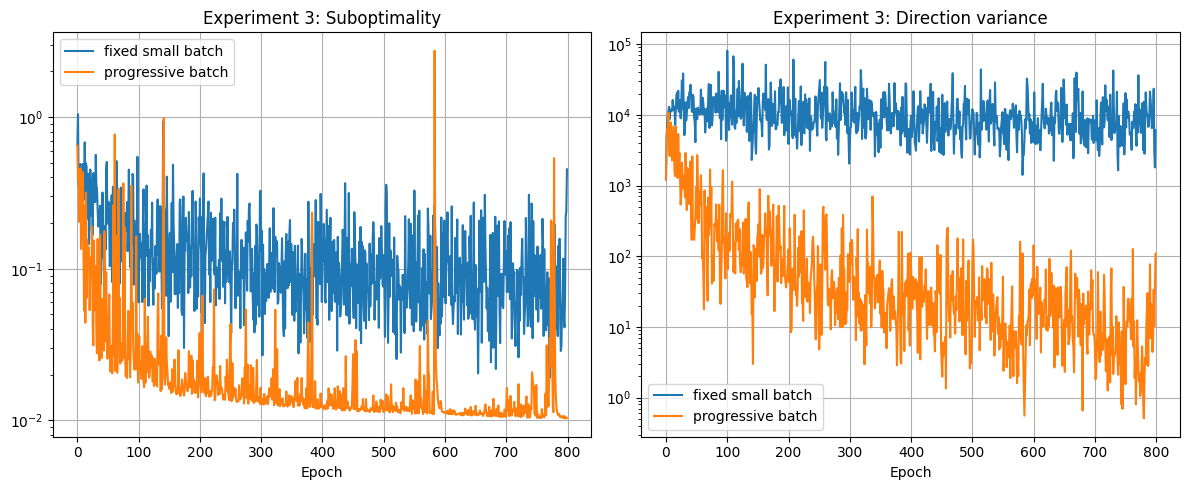

In [48]:
bs_start, bs_end = 16, 2048

hist_fixedC = run_sgd(
    X, y, lam=LAMBDA,
    epochs=EPOCHS, batch_size=bs_start,
    alpha0=ALPHA0, scheduler=None,
    seed=0, f_opt=f_opt
)

hist_prog = run_sgd_progressive(
    X, y, lam=LAMBDA,
    epochs=EPOCHS,
    bs_start=bs_start, bs_end=bs_end,
    alpha0=ALPHA0,
    seed=0, f_opt=f_opt
)

pd.DataFrame(hist_fixedC).assign(mode="fixed").to_csv(
    "csv_synthetic/expC_fixed.csv", index=False
)
pd.DataFrame(hist_prog).assign(mode="progressive").to_csv(
    "csv_synthetic/expC_progressive.csv", index=False
)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.semilogy(hist_fixedC["epoch"], hist_fixedC["subopt"], label="fixed small batch")
plt.semilogy(hist_prog["epoch"], hist_prog["subopt"], label="progressive batch")
plt.title("Experiment 3: Suboptimality")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.semilogy(hist_fixedC["epoch"], hist_fixedC["dir_var"], label="fixed small batch")
plt.semilogy(hist_prog["epoch"], hist_prog["dir_var"], label="progressive batch")
plt.title("Experiment 3: Direction variance")
plt.xlabel("Epoch")
plt.grid(True); plt.legend()

plt.tight_layout()
plt.show()

# Discussion and Takeaways

These experiments highlight key trade-offs in stochastic optimization:

**Batch size** controls the noise-stability trade-off. Small batches enable cheap, exploratory updates
but accumulate noisy gradient estimates. Large batches stabilize but reduce the effective number of updates.

**Learning-rate decay** smooths out noisy directions over time, improving final convergence at the cost
of slower initial progress. Fixed rates maintain agility but may struggle in late stages.

**Progressive batching** attempts to balance both regimes: small batches for exploration, large batches for refinement.
This strategy is now standard in large-scale deep learning to maximize computational efficiency.